<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
!pip install numpy
!pip install pandas
!pip install nltk
!pip install sklearn
!pip install numpy
!pip install xgboost


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Подготовка

In [2]:
import warnings
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from numpy.random import RandomState
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from xgboost import XGBClassifier


warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

STATE = RandomState(12345)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [6]:
data.duplicated().sum()

0

Дубликаты отсутствуют 

(89.84, '%')

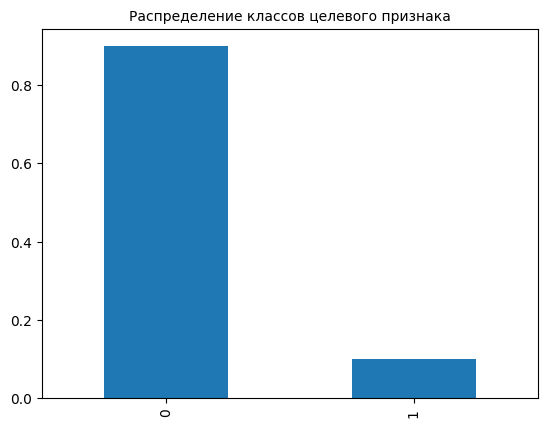

In [7]:
# Построим график по целевому признаку:
frequency = data['toxic'].value_counts(normalize=True)
frequency.plot(kind='bar')
plt.title('Распределение классов целевого признака', fontsize=10)
# вычислим в процентах количество не токсичных комментариев:
round((data['toxic'].count() - data['toxic'].sum()) / data['toxic'].count() * 100, 2), '%'

In [8]:
#Удаляю столбец Unnamed, так как он дублирует индексы.
data = data.drop(['Unnamed: 0'], axis=1)

In [9]:
# Очистила данные от лишних символов, оставила слова, состоящие из букв.
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = ' '.join(text.split())
    return text

In [10]:
data['text'] = data['text'].apply(clear_text) 

In [11]:
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


In [12]:
#Применяю функцию РОS-тэгирования слов.
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }  
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

#Применяю функцию леммализации тектов постов.
def lemm_text(text):
    text1= [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    clean = " ".join(text1)
    return clean


In [13]:
%%time
#леммализирую тексты постов:
data['text'] = data['text'].apply(lemm_text) 

CPU times: total: 38min 42s
Wall time: 39min 51s


In [14]:
data['text'].head()

0    explanation why the edits make under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not try to edit war it s ju...
3    more i can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
Name: text, dtype: object

In [15]:
#Разделяю выборки в соотношении 80/20:
features = data.drop(['toxic'], axis=1) 
target = data.toxic

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.2,
                                                                            random_state=STATE)


stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['text'].values.astype('U'))
features_test = count_tf_idf.transform(features_test['text'].values.astype('U'))

features_train.shape, target_train.shape, features_test.shape, target_test.shape

((127433, 132168), (127433,), (31859, 132168), (31859,))

In [16]:
#Смотрю соотношение 1/0 в выборках на примере target_train:
indices_1 = [i for i,x in enumerate(target_train) if x == 1]
count_1 = len(indices_1)

indices_0 = [i for i,x in enumerate(target_train) if x == 0]
count_0 = len(indices_0)

print('Доля значений 1 в тренировочной выборке:', len(indices_1) / (len(indices_1) + len(indices_0)))

Доля значений 1 в тренировочной выборке: 0.10166911239631807


In [17]:
#Уменьшаю кол-во 0 в выборках train:

data_train = data.iloc[target_train.index]
target_train_0 = data_train[data_train['toxic'] == 0]['toxic']
target_train_1 = data_train[data_train['toxic'] == 1]['toxic']


target_train_0_downsample = target_train_0.sample(target_train_1.shape[0], random_state=STATE)
target_train_downsample = pd.concat([target_train_0_downsample, target_train_1])

features_train_downsample = data.iloc[target_train_downsample.index]

features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                         target_train_downsample,
                                                         random_state=STATE)

features_train_downsample = count_tf_idf.transform(features_train_downsample['text'].values.astype('U'))

print('Соотношение в тренировочной выборке:')
print(target_train_downsample.value_counts(normalize=True))
print(features_train_downsample.shape)
print(target_train_downsample.shape)

Соотношение в тренировочной выборке:
1    0.5
0    0.5
Name: toxic, dtype: float64
(25912, 132168)
(25912,)


<b> Промежуточный вывод: </b>

Были загружены данные сервиса интернет магазина "Викишоп". Отображена информация о столбцах датафрейма, на основе которой был выявлен сильный дисбаланс классов целевого признака. На этапе получения признаков и разделения датасета на выборки отбалансирована обучающаю выборка. Проведена проверка датафрейма на наличие полных дубликатов, которая выявила их отсутствие.
В рамках подготовки данных очищены тексты комментариев от ненужных знаков, текст леммализирован, убраны стоп-слова.

## Обучение

### Модель логической регрессии

In [18]:
model_lr = LogisticRegression(random_state=STATE, n_jobs=-1)
start_time = time.time()

# Задаем сетку гиперпараметров для подбора
hyperparams = {
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'C': [1, 10, 20]
}
# Создаем объект GridSearchCV для подбора гиперпараметров
grid_cv = GridSearchCV(estimator = model_lr, param_grid = hyperparams, cv = 3,  scoring = 'f1' )

# Обучаем модель с подбором гиперпараметров
grid_cv.fit(features_train_downsample, target_train_downsample)

# Получаем лучшие гиперпараметры
best_params = grid_cv.best_params_

end_time = time.time()
selection_time_lr = end_time - start_time
print("Время подбора гиперпараметров LogisticRegression: %s секунд" % selection_time_lr)

start_time = time.time()

# Создаем новую модель с лучшими гиперпараметрами
best_model_lr = LogisticRegression(**best_params)

# Обучаем модель с лучшими гиперпараметрами
best_model_lr.fit(features_train_downsample, target_train_downsample)

end_time = time.time()
training_time_lr = end_time - start_time
print("Время обучения LogisticRegression: %s секунд" % training_time_lr)

# Вычисление F1
f1_model_lr = grid_cv.best_score_
print("Лучшие гиперпараметры модели LogisticRegression: ", best_params)
print("F1 LogisticRegression: %.2f" % f1_model_lr)

Время подбора гиперпараметров LogisticRegression: 33.43634366989136 секунд
Время обучения LogisticRegression: 0.6274046897888184 секунд
Лучшие гиперпараметры модели LogisticRegression:  {'C': 10, 'solver': 'saga'}
F1 LogisticRegression: 0.89


### Модель XGBClassifier

In [19]:
model_xgbc = XGBClassifier(random_state=STATE, n_jobs=-1)
start_time = time.time()

# Задаем сетку гиперпараметров для подбора
hyperparams = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'learning_rate': np.arange(0.0005,0.3,0.0005),
}

# Создаем объект GridSearchCV для подбора гиперпараметров
grid_cv = RandomizedSearchCV(estimator = model_xgbc, param_distributions = hyperparams, cv = 3, scoring = 'f1', n_jobs=-1)

# Обучаем модель с подбором гиперпараметров
grid_cv.fit(features_train_downsample, target_train_downsample)

# Получаем лучшие гиперпараметры
best_params = grid_cv.best_params_

end_time = time.time()
selection_time_xgbc = end_time - start_time
print("Время подбора гиперпараметров XGBClassifier: %s секунд" % selection_time_xgbc)

start_time = time.time()

# Создаем новую модель с лучшими гиперпараметрами
best_model_xgbc = XGBClassifier(**best_params)

# Обучаем модель с лучшими гиперпараметрами
best_model_xgbc.fit(features_train_downsample, target_train_downsample)

end_time = time.time()
training_time_xgbc = end_time - start_time

# Время обучения модели CatBoostClassifier
print("Время обучения XGBClassifier: %s секунд" % training_time_xgbc)

# Вычисление F1
f1_xgbc = grid_cv.best_score_
print("Лучшие гиперпараметры модели XGBClassifier: ", best_params)
print("F1 XGBClassifier: %.2f" % f1_xgbc)

Время подбора гиперпараметров XGBClassifier: 130.73158645629883 секунд
Время обучения XGBClassifier: 8.099848508834839 секунд
Лучшие гиперпараметры модели XGBClassifier:  {'max_depth': 9, 'learning_rate': 0.28800000000000003}
F1 XGBClassifier: 0.87


### Модель RandomForestClassifier

In [20]:
model_rf = RandomForestClassifier(random_state=STATE, n_jobs=-1)
start_time = time.time()

# Задаем сетку гиперпараметров для подбора
hyperparams = {
    'n_estimators': ([x for x in range(10, 30)]),
    'max_depth': ([x for x in range(1, 10)])
}

# Создаем объект GridSearchCV для подбора гиперпараметров
grid_cv = GridSearchCV(estimator = model_rf, param_grid = hyperparams, cv = 3, scoring = 'f1')

# Обучаем модель с подбором гиперпараметров
grid_cv.fit(features_train_downsample, target_train_downsample)

# Получаем лучшие гиперпараметры
best_params = grid_cv.best_params_

end_time = time.time()
selection_time_rf = end_time - start_time
print("Время подбора гиперпараметров RandomForestClassifier: %s секунд" % selection_time_rf)

start_time = time.time()

# Создаем новую модель с лучшими гиперпараметрами
best_model_rf = RandomForestClassifier(**best_params)

# Обучаем модель с лучшими гиперпараметрами
best_model_rf.fit(features_train_downsample, target_train_downsample)

end_time = time.time()
training_time_rf = end_time - start_time
print("Время обучения RandomForestClassifier: %s секунд" % training_time_rf)

# Вычисление F1
f1_rf = grid_cv.best_score_

print("Лучшие гиперпараметры модели RandomForestClassifier: ", best_params)
print("F1 RandomForestClassifier: %.2f" % f1_rf)

Время подбора гиперпараметров RandomForestClassifier: 55.55480194091797 секунд
Время обучения RandomForestClassifier: 1.4160988330841064 секунд
Лучшие гиперпараметры модели RandomForestClassifier:  {'max_depth': 9, 'n_estimators': 29}
F1 RandomForestClassifier: 0.77


<b> Промежуточный вывод: </b>

Обучены следующие модели:
   * LogisticRegression;
   * XGBClassifier;
   * RandomForestClassifier.
      
Для каждой модели подоброны лучшие гиперпараметры, посчитано время обучения и метрика F1.

## Анализ моделей

In [21]:
pd.DataFrame({'Модель': ['LogisticRegression', 'XGBClassifier', 'RandomForestClassifier'],
              'Время подбора гипперпараметров (сек.)': [selection_time_lr, selection_time_xgbc, selection_time_rf],
              'Время обучения (сек.)': [training_time_lr, training_time_xgbc, training_time_rf],
              'F1': [f1_model_lr, f1_xgbc, f1_rf]})

,Модель,Время подбора гипперпараметров (сек.),Время обучения (сек.),F1
0,LogisticRegression,33.436344,0.627405,0.891527
1,XGBClassifier,130.731586,8.099849,0.872963
2,RandomForestClassifier,55.554802,1.416099,0.767537


Значения метрики F1 на всех моделях больше требуемого 0.75. Наилучший результат показала модель LogisticRegression с значением 0.89.

## Вывод

1. Данные загружены, изучены и разделены на обучающую и тестовую выборки. ыборки отбалансирована обучающаю выборка. Проведена проверка на наличие неявных дубликатов, которая выявила их отсутствие. В рамках подготовки данных очищены тексты комментариев от ненужных знаков, текст леммализирован, убраны стоп-слова.
2. Обучены следующие модели:
    * LogisticRegression;
    * XGBClassifier;
    * RandomForestClassifier.
3. Значения метрики F1 на всех моделях больше требуемого 0.75.

<b> Лучшей моделью является LogisticRegression </b>:
* время подбора гипперпараметров (сек.): 30.96;
* время обучения (сек.): 0.64;
* F1: 0.89.